# Импорт пакетов
- **numpy** - для работы с массивами
- **matplotlib.pyplot** - для визуализации данных
- **keras** - для глубоких нейронных сетей
 - **application** - предопученные НС
 - **models.Sequential** - типы архитектуры моделей
 - **layers.Dense, layers.Dropout, layers.Flatten, layers.Convolution2D, layers.MaxPooling2D** - виды слоёв: полносвязный слой; дропаут слой; сжимающий слой; свёрточный слой; пулл слой;
 - **utils.np_utils** - доп. утилиты
 - **preprocessing.image.ImageDataGenerator** - генератор для датааугментации
 - **keras.callbacks.ModelCheckpoint, keras.callbacks.EarlyStopping, keras.callbacks.TensorBoard** - обратные отклики: точки сохранения для модели; преждевременная остановка; тензорборд;
 - **optimizers.SGD, optimizers.Adam, MadGrad.** - оптимизаторы: стохастический градиентный спуск; оценка адаптивного момента; [моментальный адаптивный метод двойного усредненного градиента](https://arxiv.org/pdf/2101.11075.pdf)
- **sklearn.model_selection.train_test_split** - разделение на тренеровочную и тестовую выборку
- **tensorflow** - для ГНС
- **datetime** - время для сохранения логов

In [1]:
%load_ext tensorboard

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import applications
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Convolution2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import SGD, Adam
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_addons as tfa
from scipy.stats import kruskal
import datetime

# Импорт данных и установка глобальных переменных

Устанавливаем:
1. **img_size** - размер фотографий, которые были установленны при препроцессинге
2. **_lambda** - $\lambda$, которая будет использоваться в L2/L1 регулярезации, при их необходимости.

In [3]:
img_size = 256
_lambda = 0.01

Загружаем данные

In [4]:
data = np.load('processed_val_images.npy')
# Perform the float32 converting here cuz I obtain an error due to inabillity to allocate the memory for the float64
data = data.astype('float32')

labels = np.load('processed_val_labels.npy')
print(data.shape)
print(labels.shape)

(8239, 256, 256, 3)
(8239,)


Разделяем данные на тренеровочные и тестовые:

In [5]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, train_size = 0.8, random_state = 20)

nb_classes = 2
y_train = np.array(y_train)
y_test = np.array(y_test)
Y_train = to_categorical(y_train)
Y_test = to_categorical(y_test)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

print("Training matrix shape", X_train.shape)
print("Testing matrix shape", X_test.shape)

print("Training label shape", Y_train.shape)
print("Testing label shape", Y_test.shape)

Training matrix shape (6591, 256, 256, 3)
Testing matrix shape (1648, 256, 256, 3)
Training label shape (6591, 2)
Testing label shape (1648, 2)


Оцениваем распределение тренеровочных и тестовых данных. Поскольку данных слишком много ($2252 \times 256 \times 256 \times 3$), вводим их оценочную репрезентацию, где каждая картинка представлена как:
$$
I_s = \log{\left(\frac{\mu_I}{\sigma}\right)}
$$

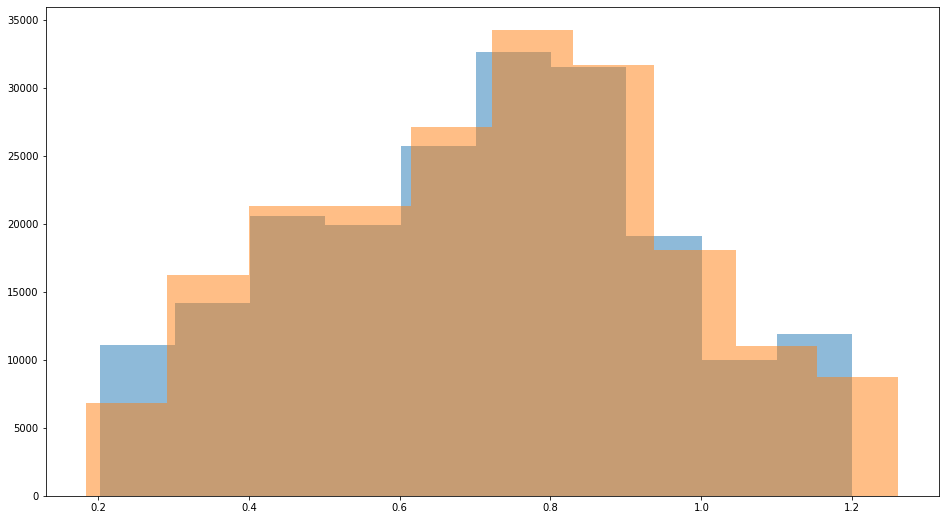

In [6]:
def normalized_mean(arr):
    return np.log(np.mean(arr)/np.std(arr))

plt.figure(figsize=(16,9))
plt.hist(np.apply_along_axis(normalized_mean, 0, X_train.reshape(6591,-1)), alpha=0.5, label='train')
plt.hist(np.apply_along_axis(normalized_mean, 0, X_test.reshape(1648,-1)), alpha=0.5, label='test')
plt.show()

Сравниваем разные каналы

In [7]:
print(np.median(data[:,:,:, 0]))
print(np.median(data[:,:,:, 1]))
print(np.median(data[:,:,:, 2]))

0.34519044
0.40313074
0.57101715


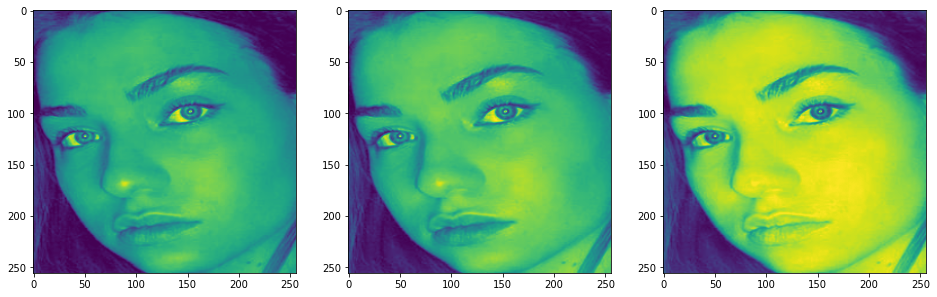

In [8]:
fig, ax = plt.subplots(1, 3, figsize=(16,9))

ax[0].imshow(data[100,:,:, 0])
ax[1].imshow(data[100,:,:, 1])
ax[2].imshow(data[100,:,:, 2])

plt.show()

# Модель

Модель следующая:
$$
\hat{y} = \text{FC}_2(\text{Dropout}(\text{FC}_{192}(\text{FC}_{192}(\text{Flatten}(\text{VGG19}(x))))))
$$

In [9]:
model = applications.VGG19(weights="imagenet", include_top=False, input_shape = (img_size, img_size, 3))

Поскольку, мы имеем слишком мало обучающих данных, и данные похожи на **imagenet** - отключаем все слои у VGG19.

In [10]:
for layer in model.layers:
        layer.trainable = False

In [11]:
model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

Посредством тюнинга гиперпараметров я получил:
* Количество нейронов для первого FC слоя: 192 нейронов
* Количество нейронов для второго FC слоя: 192 нейронов
* Dropout rate: 30%

Дабы получить одинаковую воспроизводимость для каждого запуска инициализируем слои с помощью HE-et-al:
$$
\begin{aligned}
&\hat{y} = \sum_{i}^{N}{w_ix_i}\\
&Var{(w_i)} = \frac{2}{fan\_in}, \qquad \text{где }fan\_in \text{ - количество входных единиц в весовом тензоре}
\end{aligned}
$$

Баесы же, устанавливаем на ноль.

In [12]:
top_model = model.output
top_model = Flatten(name='flatten')(top_model)
top_model = Dense(units=192, activation='relu', kernel_initializer='he_uniform', bias_initializer='zeros')(top_model)
top_model = Dense(units=192, activation='relu', kernel_initializer='he_uniform', bias_initializer='zeros')(top_model)
top_model = Dropout(0.3)(top_model) # test
top_model = Dense(2, activation='softmax')(top_model)

In [13]:
new_model = tf.keras.Model(inputs=model.input, outputs=top_model)

In [16]:
new_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

Создаём датааугментор:
* поворачиваем фото на 15 градусов влево/вправо
* сдвигаем на 0.2 влево/вправо/вверх/вниз.

In [14]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
)

train_batchsize = 64

train_generator = train_datagen.flow(
    X_train,
    Y_train,
    batch_size=train_batchsize
)

train_samples = train_generator.n

Создаем три точки отклика:

1. Точка сохранения модели
 - Отслеживаем минимальные валидационные лоссы.
 - Сохраняем только лучший вариант.
2. Точка ранней остановы
 - Отслеживаем минимальные валидационные лоссы.
 - Если 3 эпохи не получается преодолеть минимальные валидационные лоссы, то останавливаем модель.
3. Создаём тензорборд и директорию для логов к нему

Лоссы: `binary_crossentropy`, т.к. мы имеем только два класса для классификации

Оптимизатор: Я протестировал три оптимизатора **Adam**, **MadGrad**, **SGD+momentum**: первые два слищком быстро сходились, даже при маленьком `learning_rate`. Поэтому выбор пал на SGD+momentum:
$$
\begin{aligned}
&v_{t} = \gamma{v}_{t-1} + \eta\nabla_{\theta}J\left(\theta\right), \qquad \text{где }J(\theta) \text{ это матрица Якоби по параметрам}\\
&\theta_{t} = \theta_{t-1} - v_{t}
\end{aligned}
$$

Метрика: `MCC`,

In [15]:
checkpoint = ModelCheckpoint(
    "model_256x256_6kimages.h5",
    monitor="val_loss",
    mode="min",
    save_best_only=True,
    verbose=1
)


earlystop = EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=3,
    verbose=1,
    restore_best_weights=True
)

tensorboard = TensorBoard(
    log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"), 
    histogram_freq=1
)

calbacks = [earlystop, checkpoint, tensorboard]

In [17]:
new_model.compile(loss='binary_crossentropy',
              optimizer=SGD(learning_rate=1e-4, decay=1e-6, momentum=0.9, nesterov=True), # MadGrad(learning_rate=1e-4),
              metrics=['accuracy'])
#tfa.metrics.MatthewsCorrelationCoefficient(num_classes=2)

In [ ]:
m = new_model.fit(train_generator,
                  steps_per_epoch=train_samples//train_batchsize,
                  epochs=60,
                  verbose=2, 
                  callbacks=calbacks,
                  validation_data=(X_test, Y_test))

Epoch 1/60


In [3]:
%tensorboard --logdir logs/fit

Reusing TensorBoard on port 6006 (pid 14164), started 1 day, 2:28:24 ago. (Use '!kill 14164' to kill it.)

In [26]:
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'auc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'auc' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    ## Loss
    plt.figure(1, figsize=(16,9))
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    #plt.xlim(xmin=0)
    plt.ylim(ymin=0)
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    ## Accuracy
    plt.figure(2, figsize=(16,9))
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    #plt.ylim(0, 1)    
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

No handles with labels found to put in legend.


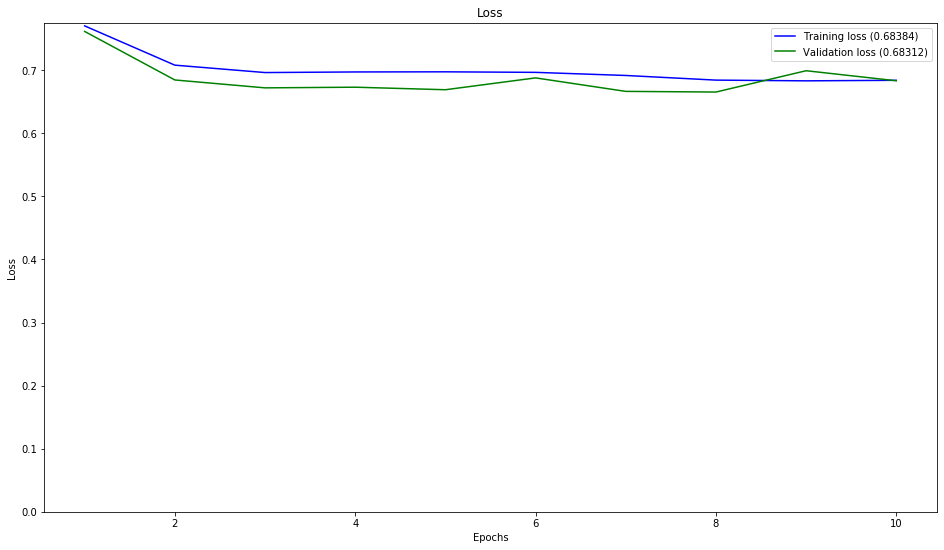

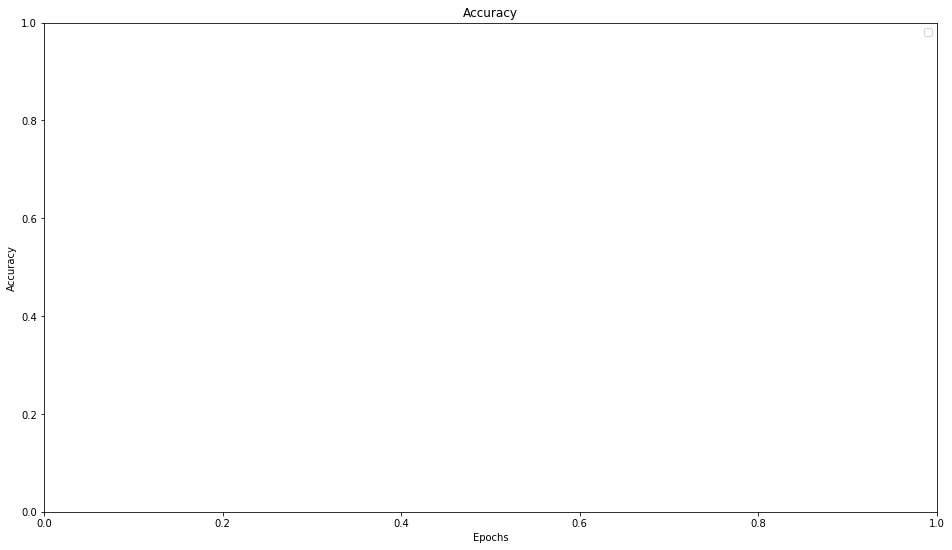

In [27]:
plot_history(m)